In [1]:
import json
import matplotlib.pyplot as plt

from glob import glob
from tabulate import tabulate

import sys
sys.path.append('../../Data/auxiliary/')

In [2]:
def replace_special_char(string):
    changes = [('á', 'a'), ('à', 'a'), ('â', 'a'), ('ã', 'a'),
               ('é', 'e'), ('ê', 'e'), ('í', 'i'), ('ó', 'o'),
               ('ô', 'o'), ('õ', 'o'), ('ú', 'u'), ('ç', 'c')]
    
    for change in changes: string = string.replace(change[0], change[1])
    return string

In [3]:
total_games = 0
total_derbies = 0
cards = dict()
cards_on_derbies = dict()
cards_time = [0] * 90
cards_time_on_derbies = [0] * 90
goals = dict()
goals_time = [0] * 90
goals_time_on_derbies = [0] * 90
summary = dict()
all_players = dict()
for file in sorted(glob('../../Data/results/processed/Serie_A_*_squads.json')):
    season = int(file[-16:-12])
    if season >= 2025: continue
    cards[season] = 0
    goals[season] = 0
    summary[season] = dict()
    all_players[season] = set()

    info_file = file.replace('squads', 'games')
    with open(file, 'rb') as f: data = json.load(f)
    with open(info_file, 'rb') as f: info = json.load(f)
    for game in data:
        is_derby = False
        home_club = info[game]['Home']
        away_club = info[game]['Away']
        total_games += 1
        if home_club[-2:] == away_club[-2:]:
            total_derbies += 1
            is_derby = True
        
        if home_club not in summary[season]: summary[season][home_club] = set()
        if away_club not in summary[season]: summary[season][away_club] = set()
        
        passed_time = 0
        for sub_game in data[game]:
            if sub_game == 'Summary': continue
            cards[season] += len(data[game][sub_game]['Home']['Cards'])
            cards[season] += len(data[game][sub_game]['Away']['Cards'])
            if len(data[game][sub_game]['Home']['Cards']) != 0:
                for card in data[game][sub_game]['Home']['Cards']:
                    (minute, is_in_injury_time), player = card
                    if is_in_injury_time: continue
                    minute += passed_time
                    cards_time[minute - 1] += 1
                    if is_derby: cards_time_on_derbies[minute - 1] += 1

            if len(data[game][sub_game]['Away']['Cards']) != 0:
                for card in data[game][sub_game]['Away']['Cards']:
                    (minute, is_in_injury_time), player = card
                    if is_in_injury_time: continue
                    minute += passed_time
                    cards_time[minute - 1] += 1
                    if is_derby: cards_time_on_derbies[minute - 1] += 1
            
            goals[season] += len(data[game][sub_game]['Home']['Goals'])
            goals[season] += len(data[game][sub_game]['Away']['Goals'])
            if len(data[game][sub_game]['Home']['Goals']) != 0:
                for goal in data[game][sub_game]['Home']['Goals']:
                    (minute, is_in_injury_time), player = goal
                    if is_in_injury_time: continue
                    minute += passed_time
                    goals_time[minute - 1] += 1
                    if is_derby: goals_time_on_derbies[minute - 1] += 1

            if len(data[game][sub_game]['Away']['Goals']) != 0:
                for goal in data[game][sub_game]['Away']['Goals']:
                    (minute, is_in_injury_time), player = goal
                    if is_in_injury_time: continue
                    minute += passed_time
                    goals_time[minute - 1] += 1
                    if is_derby: goals_time_on_derbies[minute - 1] += 1

            home_squad = data[game][sub_game]['Home']['Squad']
            away_squad = data[game][sub_game]['Away']['Squad']
            
            summary[season][home_club] = summary[season][home_club].union(set(home_squad))
            summary[season][away_club] = summary[season][away_club].union(set(away_squad))
            
            all_players[season] = all_players[season].union(set(home_squad))
            all_players[season] = all_players[season].union(set(away_squad))
            
            passed_time += data[game][sub_game]['Time']

for season in summary:
    all_players[season] = len(all_players[season])
    for club in summary[season]:
        summary[season][club] = len(summary[season][club])
    
    summary[season] = sum(summary[season].values()) / len(summary[season])


In [4]:
with open('../../Data/results/processed/Serie_A_2013_squads.json', 'rb') as f: data = json.load(f)
data['001']

{'Summary': {'Home': 'Vasco da Gama / RJ',
  'Away': 'Portuguesa / SP',
  'Result': '1 X 0',
  'Date': '25/05/2013',
  'Time': '18:30',
  'Stadium': 'São Januário / Rio de Janeiro'},
 '0': {'Home': {'Squad': ['146379',
    '186825',
    '430895',
    '165075',
    '402413',
    '307406',
    '357424',
    '317751',
    '156194',
    '167111',
    '175011'],
   'Cards': [[[28, False], '430895']],
   'Goals': [[[47, False], '402413']]},
  'Away': {'Squad': ['159483',
    '158204',
    '160789',
    '134212',
    '151104',
    '160357',
    '176908',
    '138048',
    '190258',
    '136911',
    '188158'],
   'Cards': [[[23, False], '176908']],
   'Goals': []},
  'Time': 62},
 '1': {'Home': {'Squad': ['146379',
    '186825',
    '430895',
    '165075',
    '402413',
    '307406',
    '357424',
    '317751',
    '156194',
    '167111',
    '143841'],
   'Cards': [],
   'Goals': []},
  'Away': {'Squad': ['159483',
    '158204',
    '160789',
    '134212',
    '151104',
    '160357',
    '17

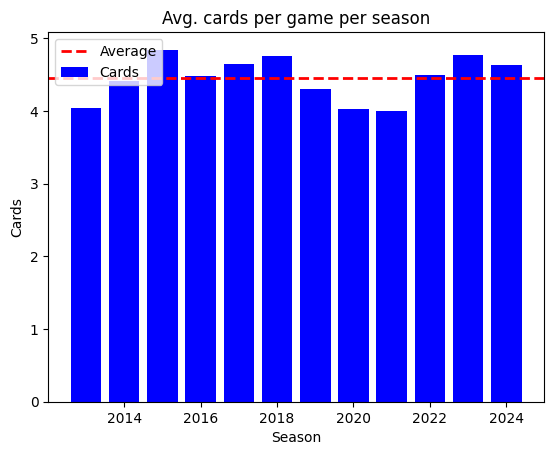

In [5]:
season = list(cards.keys())
value = list(cards.values())
value = [v / 380 for v in value]
mean = sum(value) / len(value)

fig, ax = plt.subplots()
ax.bar(season, value, color='blue', label='Cards')
ax.axhline(y=mean, color='red', linewidth=2, linestyle='--', label='Average')
ax.set_title('Avg. cards per game per season')
ax.set_xlabel('Season')
ax.set_ylabel('Cards')
ax.legend()

plt.savefig('../figures/cards_per_game_per_season.png', dpi=300, bbox_inches='tight')
plt.show()


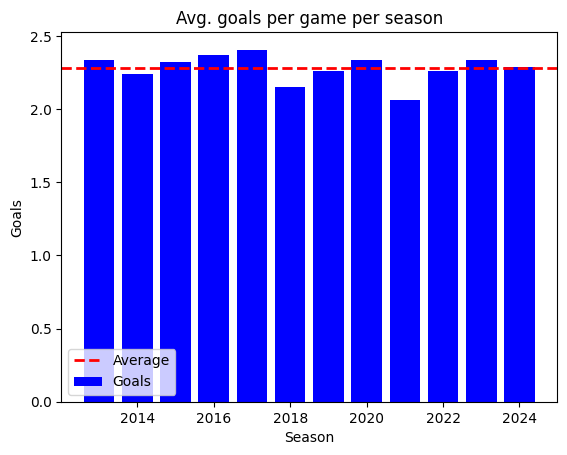

In [6]:
season = list(goals.keys())
value = list(goals.values())
value = [v / 380 for v in value]
mean = sum(value) / len(value)

fig, ax = plt.subplots()
ax.bar(season, value, color='blue', label='Goals')
ax.axhline(y=mean, color='red', linewidth=2, linestyle='--', label='Average')
ax.set_title('Avg. goals per game per season')
ax.set_xlabel('Season')
ax.set_ylabel('Goals')
ax.legend()

plt.savefig('../figures/goals_per_game_per_season.png', dpi=300, bbox_inches='tight')
plt.show()


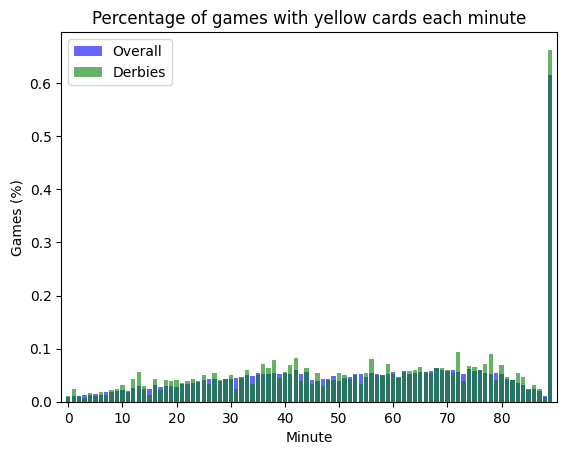

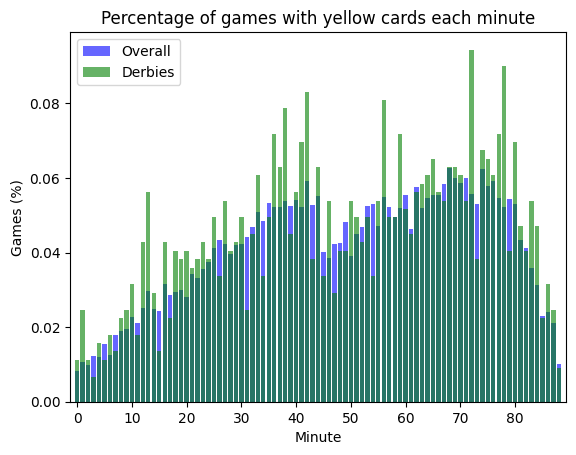

In [7]:
x_labels = list(range(90))

# total_cards = sum(cards_time)
# total_cards_on_derbies = sum(cards_time_on_derbies)
cards_time = [cards / total_games for cards in cards_time]
cards_time_on_derbies = [cards / total_derbies for cards in cards_time_on_derbies]

fig, ax = plt.subplots()

bars1 = ax.bar(x_labels, cards_time, color='blue', alpha=0.6, label='Overall')
bars2 = ax.bar(x_labels, cards_time_on_derbies, color='green', alpha=0.6, label='Derbies')

ax.set_title('Percentage of games with yellow cards each minute')
ax.set_xlabel('Minute')
ax.set_ylabel('Games (%)')
ax.set_xticks(range(0, 90, 10))
ax.set_xticklabels(range(0, 90, 10))
ax.legend()
ax.margins(x=0.01)

plt.savefig('../figures/cards_distribution_overlay.png', dpi=300, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()

bars1 = ax.bar(x_labels[:-1], cards_time[:-1], color='blue', alpha=0.6, label='Overall')
bars2 = ax.bar(x_labels[:-1], cards_time_on_derbies[:-1], color='green', alpha=0.6, label='Derbies')

ax.set_title('Percentage of games with yellow cards each minute')
ax.set_xlabel('Minute')
ax.set_ylabel('Games (%)')
ax.set_xticks(range(0, 90, 10))
ax.set_xticklabels(range(0, 90, 10))
ax.legend()
ax.margins(x=0.01)

plt.savefig('../figures/cards_distribution_overlay_wo_minute_90.png', dpi=300, bbox_inches='tight')
plt.show()


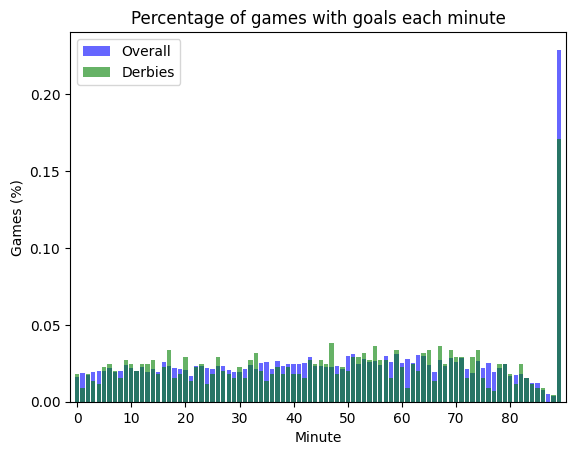

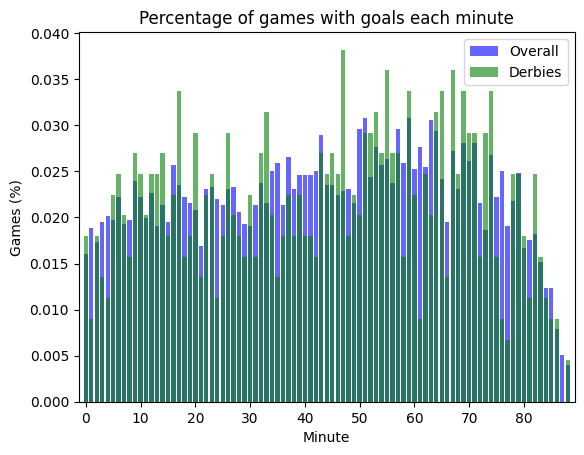

In [8]:
goals_time = [goals / total_games for goals in goals_time]
goals_time_on_derbies = [goals / total_derbies for goals in goals_time_on_derbies]

fig, ax = plt.subplots()

bars1 = ax.bar(x_labels, goals_time, color='blue', alpha=0.6, label='Overall')
bars2 = ax.bar(x_labels, goals_time_on_derbies, color='green', alpha=0.6, label='Derbies')

ax.set_title('Percentage of games with goals each minute')
ax.set_xlabel('Minute')
ax.set_ylabel('Games (%)')
ax.set_xticks(range(0, 90, 10))
ax.set_xticklabels(range(0, 90, 10))
ax.legend()
ax.margins(x=0.01)

plt.savefig('../figures/goals_distribution_overlay.png', dpi=300, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()

bars1 = ax.bar(x_labels[:-1], goals_time[:-1], color='blue', alpha=0.6, label='Overall')
bars2 = ax.bar(x_labels[:-1], goals_time_on_derbies[:-1], color='green', alpha=0.6, label='Derbies')

ax.set_title('Percentage of games with goals each minute')
ax.set_xlabel('Minute')
ax.set_ylabel('Games (%)')
ax.set_xticks(range(0, 90, 10))
ax.set_xticklabels(range(0, 90, 10))
ax.legend()
ax.margins(x=0.01)

plt.savefig('../figures/goals_distribution_overlay_wo_minute_90.png', dpi=300, bbox_inches='tight')
plt.show()


In [9]:
summary = dict()
for file in sorted(glob('../../Data/results/processed/Serie_A_*_squads.json')):
    season = int(file[-16:-12])
    if season >= 2025: continue
    info_file = file.replace('squads', 'games')
    with open(file, 'rb') as f: data = json.load(f)
    with open(info_file, 'rb') as f: info = json.load(f)
    for game in data:
        home_club = info[game]['Home']
        away_club = info[game]['Away']
        if home_club not in summary: summary[home_club] = dict()
        if away_club not in summary: summary[away_club] = dict()
        if season not in summary[home_club]: summary[home_club][season] = set()
        if season not in summary[away_club]: summary[away_club][season] = set()
        for sub_game in data[game]:
            if sub_game == 'Summary': continue
            home_squad = set(data[game][sub_game]['Home']['Squad'])
            away_squad = set(data[game][sub_game]['Away']['Squad'])
            summary[home_club][season] = summary[home_club][season].union(home_squad)
            summary[away_club][season] = summary[away_club][season].union(away_squad)

for club in summary:
    for season in summary[club]:
        summary[club][season] = len(summary[club][season])
    
    summary[club] = sum(summary[club].values()) / len(summary[club])

summary

{'Vasco da Gama / RJ': 39.5,
 'Portuguesa / SP': 38.0,
 'Fluminense / RJ': 36.583333333333336,
 'Athletico Paranaense / PR': 36.166666666666664,
 'Corinthians / SP': 34.916666666666664,
 'Botafogo / RJ': 37.7,
 'Vitória / BA': 40.166666666666664,
 'Internacional / RS': 37.63636363636363,
 'Grêmio / RS': 38.54545454545455,
 'Náutico / PE': 41.0,
 'Ponte Preta / SP': 39.25,
 'São Paulo / SP': 35.5,
 'Criciúma / SC': 42.0,
 'Bahia / BA': 34.77777777777778,
 'Cruzeiro / MG': 36.55555555555556,
 'Goiás / GO': 38.714285714285715,
 'Coritiba / PR': 41.875,
 'Atlético Mineiro / MG': 34.75,
 'Santos / SP': 38.18181818181818,
 'Flamengo / RJ': 36.0,
 'Figueirense / SC': 39.666666666666664,
 'Sport / PE': 33.857142857142854,
 'Palmeiras / SP': 36.18181818181818,
 'Chapecoense / SC': 37.142857142857146,
 'Joinville / SC': 46.0,
 'Avaí / SC': 38.0,
 'Santa Cruz / PE': 41.0,
 'América / MG': 39.8,
 'Atlético Goianiense / GO': 34.2,
 'Paraná / PR': 50.0,
 'Ceará / CE': 37.2,
 'CSA / AL': 40.0,
 'Fort

In [10]:
clubs = dict()
players = dict()
championships = ['Serie_A', 'Serie_B', 'Serie_C', 'Serie_D', 'CdB']
for championship in championships:
    clubs[championship] = dict()
    players[championship] = dict()
    for file in sorted(glob(f'../../Data/results/processed/{championship}_*_squads.json')):
        season = int(file[-16:-12])
        if season >= 2025: continue
        clubs[championship][season] = set()
        players[championship][season] = set()

        info_file = file.replace('squads', 'games')
        with open(file, 'rb') as f: data = json.load(f)
        with open(info_file, 'rb') as f: info = json.load(f)
        for game in data:
            home_club = info[game]['Home']
            away_club = info[game]['Away']
            if home_club not in clubs[championship][season]: clubs[championship][season].add(home_club)
            if away_club not in clubs[championship][season]: clubs[championship][season].add(away_club)
            for sub_game in data[game]:
                if sub_game == 'Summary': continue
                home_squad = set(data[game][sub_game]['Home']['Squad'])
                away_squad = set(data[game][sub_game]['Away']['Squad'])
                players[championship][season] = players[championship][season].union(home_squad)
                players[championship][season] = players[championship][season].union(away_squad)


In [11]:
total_players = dict()
for championship in championships:
    total_players[championship] = dict()
    for season in players[championship]:
        total_players[championship][season] = len(players[championship][season])

cumulative_players_per_season = dict()
for season in players['Serie_A']:
    players_on_season = set()
    for championship in championships:
        players_on_season = players_on_season.union(players[championship][season])
    
    cumulative_players_per_season[season] = len(players_on_season)


cumulative_players_per_championship = dict()
overall_players = set()
for championship in championships:
    players_on_championship = set()
    for season in total_players[championship]:
        players_on_championship = players_on_championship.union(players[championship][season])
        overall_players = overall_players.union(players[championship][season])
    
    cumulative_players_per_championship[championship] = len(players_on_championship)

overall_players = len(overall_players)

table = [['Season', 'Serie A', 'Serie B', 'Serie C', 'Serie D', 'CdB', 'Total unique players']]
for season in cumulative_players_per_season:
    row = [season]
    for championship in championships:
        row.append(total_players[championship][season])
    
    row.append(cumulative_players_per_season[season])
    table.append(row)

row = ['Total unique players']
for championship in championships:
    row.append(cumulative_players_per_championship[championship])

row.append(overall_players)
table.append(row)

print(tabulate(table, tablefmt='latex'))

\begin{tabular}{lllllll}
\hline
 Season               & Serie A & Serie B & Serie C & Serie D & CdB  & Total unique players \\
 2013                 & 709     & 811     & 687     & 1061    & 1799 & 3644                 \\
 2014                 & 736     & 833     & 650     & 1043    & 1872 & 3671                 \\
 2015                 & 715     & 805     & 667     & 1056    & 1897 & 3672                 \\
 2016                 & 722     & 775     & 666     & 1603    & 1847 & 4012                 \\
 2017                 & 722     & 731     & 601     & 1551    & 1591 & 3783                 \\
 2018                 & 720     & 740     & 584     & 1563    & 1605 & 3745                 \\
 2019                 & 691     & 740     & 618     & 1553    & 1579 & 3748                 \\
 2020                 & 733     & 791     & 690     & 2032    & 1695 & 4381                 \\
 2021                 & 713     & 733     & 674     & 2049    & 1851 & 4398                 \\
 2022             

In [12]:
total_clubs = dict()
for championship in championships:
    total_clubs[championship] = dict()
    for season in clubs[championship]:
        total_clubs[championship][season] = len(clubs[championship][season])

cumulative_clubs_per_season = dict()
for season in clubs['Serie_A']:
    clubs_on_season = set()
    for championship in championships:
        clubs_on_season = clubs_on_season.union(clubs[championship][season])
    
    cumulative_clubs_per_season[season] = len(clubs_on_season)


cumulative_clubs_per_championship = dict()
overall_clubs = set()
for championship in championships:
    clubs_on_championship = set()
    for season in total_clubs[championship]:
        clubs_on_championship = clubs_on_championship.union(clubs[championship][season])
        overall_clubs = overall_clubs.union(clubs[championship][season])
    
    cumulative_clubs_per_championship[championship] = len(clubs_on_championship)

overall_clubs = len(overall_clubs)

table = [['Season', 'Serie A', 'Serie B', 'Serie C', 'Serie D', 'CdB', 'Total unique clubs']]
for season in cumulative_clubs_per_season:
    row = [season]
    for championship in championships:
        row.append(total_clubs[championship][season])
    
    row.append(cumulative_clubs_per_season[season])
    table.append(row)

row = ['Total unique clubs']
for championship in championships:
    row.append(cumulative_clubs_per_championship[championship])

row.append(overall_clubs)
table.append(row)

print(tabulate(table, tablefmt='latex'))

\begin{tabular}{lllllll}
\hline
 Season             & Serie A & Serie B & Serie C & Serie D & CdB & Total unique clubs \\
 2013               & 20      & 21      & 21      & 40      & 88  & 130                \\
 2014               & 20      & 20      & 20      & 41      & 87  & 132                \\
 2015               & 20      & 20      & 20      & 40      & 87  & 125                \\
 2016               & 20      & 20      & 20      & 68      & 86  & 147                \\
 2017               & 20      & 20      & 20      & 68      & 91  & 134                \\
 2018               & 20      & 20      & 20      & 69      & 91  & 138                \\
 2019               & 20      & 20      & 20      & 68      & 91  & 131                \\
 2020               & 20      & 20      & 20      & 68      & 91  & 136                \\
 2021               & 20      & 20      & 20      & 69      & 92  & 134                \\
 2022               & 20      & 20      & 20      & 64      & 92  & 